# Reading live data for prediction

To predict on real time it is needed to have online measurement.

Ayuntamiento de Madrid in its web (https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=41e01e007c9db410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
about AirQuality, provide measurements for all Air stations updated in real time, being the data updated every hour. This data update will happen between the minutes 20 and 30 of every hour.


**Disclaimer of live data: This data is live data automatically measured by the AirStations without any quality check, so data is pending to be reviewed and validated.**



In [31]:
#Libraries
#########

import requests
import numpy as np
import pandas as pd
import io
import time
import datetime
from datetime import timedelta
from datetime import datetime

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sbn
%matplotlib inline

import pickle

#Libraries/functions for Modelling ARIMA
#######################################

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm

In [14]:

#Reading Air quality live data from online service from Ayuntamiento de Madrid web
######################################################################

url = 'https://www.mambiente.madrid.es/opendata/horario.csv'

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

response = requests.get(url, headers=headers)
df_airlive = pd.read_csv(io.StringIO(response.text), sep=';')

#Reading Meteo live data from online service from Ayuntamiento de Madrid web
######################################################################

url = 'https://datos.madrid.es/egob/catalogo/300392-11041819-meteorologia-tiempo-real.csv'

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

response = requests.get(url, headers=headers)
df_meteolive = pd.read_csv(io.StringIO(response.text), sep=';')

In [15]:
df_meteolive.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,81,28079102_81_98,2021,12,16,0.8,V,...,0,N,0,N,0,N,0,N,0,N
1,28,79,102,82,28079102_82_98,2021,12,16,34.0,V,...,0,N,0,N,0,N,0,N,0,N
2,28,79,102,83,28079102_83_98,2021,12,16,6.5,V,...,0,N,0,N,0,N,0,N,0,N
3,28,79,102,86,28079102_86_98,2021,12,16,47.0,V,...,0,N,0,N,0,N,0,N,0,N
4,28,79,102,87,28079102_87_98,2021,12,16,946.0,V,...,0,N,0,N,0,N,0,N,0,N


In [16]:
df_airlive.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,8,1,28079008_1_38,2021,12,16,5.0,V,...,0,N,0,N,0,N,0,N,0,N
1,28,79,8,6,28079008_6_48,2021,12,16,0.7,V,...,0,N,0,N,0,N,0,N,0,N
2,28,79,8,7,28079008_7_8,2021,12,16,88.0,V,...,0,N,0,N,0,N,0,N,0,N
3,28,79,8,8,28079008_8_8,2021,12,16,85.0,V,...,0,N,0,N,0,N,0,N,0,N
4,28,79,8,9,28079008_9_47,2021,12,16,19.0,V,...,0,N,0,N,0,N,0,N,0,N


In [17]:
#Transforming AirQuality_live data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
###############################################################################################################

df_airlive = df_airlive[(df_airlive['MAGNITUD'] == 8)]
df_airlive ['DATE'] = pd.to_datetime({'year': df_airlive['ANO'],
                                                          'month': df_airlive['MES'],
                                                          'day': df_airlive['DIA']})
df_airlive = pd.melt(df_airlive, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])
df_airlive['HOUR'] = [int(x[1:3]) for x in df_airlive.variable.values]
df_airlive['TIME'] = df_airlive['DATE'].astype(str) + ' ' + (df_airlive['HOUR']-1).astype(str) + ':59:59'
df_airlive['TIME']=pd.to_datetime(df_airlive['TIME'] )
df_airlive.index = df_airlive.TIME
df_airlive.rename(columns={'value':'NO2_index'},inplace=True)
df_airlive.rename(columns={'ESTACION':'AirStationId'},inplace=True)
df_airlive.drop(['variable'], axis = 'columns', inplace=True)
df_airlive.drop(['MAGNITUD'], axis = 'columns', inplace=True)
df_airlive.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)



In [18]:
#Transforming Weather Quality_live data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
###############################################################################################################


df_meteolive ['DATE'] = pd.to_datetime({'year': df_meteolive['ANO'],
                                                          'month': df_meteolive['MES'],
                                                          'day': df_meteolive['DIA']})

# Dataframe transformation, keeping needed data and creating measured variables originally in columns
df_meteolive = pd.melt(df_meteolive, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

#Creation of HOUR field based on the hourly columns manipulated with melt funcion and now storage in "variable" field
df_meteolive['HOUR'] = [int(x[1:3]) for x in df_meteolive.variable.values]

#Creation of timestamp field & indexing time
df_meteolive['TIME'] = df_meteolive['DATE'].astype(str) + ' ' + (df_meteolive['HOUR']-1).astype(str) + ':59:59'
df_meteolive['TIME']=pd.to_datetime(df_meteolive['TIME'] )

# Cleaning and rename columns
df_meteolive.drop(['variable'], axis = 'columns', inplace=True)
df_meteolive = df_meteolive[["ESTACION", "MAGNITUD","PUNTO_MUESTREO", "TIME", "DATE", "HOUR", "value"]]
df_meteolive.rename(columns={'ESTACION':'WeatherStationId'},inplace=True)
df_meteolive.rename(columns={'PUNTO_MUESTREO':'WEATHER_METRIC_POINT'},inplace=True)

# Moving different magnitud values from "long to wide"
df_meteolive = df_meteolive.pivot_table(index=["TIME", "WeatherStationId"], columns='MAGNITUD', values='value').reset_index()
df_meteolive.reset_index(inplace=True, drop=True)
df_meteolive.columns.name = None

#Rename column parameters created from pivot
df_meteolive.rename(columns={80:'UV'},inplace=True)
df_meteolive.rename(columns={81:'WindSpeed'},inplace=True)
df_meteolive.rename(columns={82:'WindDirection'},inplace=True)
df_meteolive.rename(columns={83:'Temperature'},inplace=True)
df_meteolive.rename(columns={86:'Humidity'},inplace=True)
df_meteolive.rename(columns={87:'BarPressure'},inplace=True)
df_meteolive.rename(columns={88:'SolarRadiation'},inplace=True)
df_meteolive.rename(columns={89:'Precipitation'},inplace=True)

In [19]:
# FILL NaN STRATEGY 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
####################################################################################

# Creating columns with the median values of all stations to be added to the WeatherIndex dataframe to fill NaNs
WindSpeedMedian = df_meteolive.groupby("TIME").agg(MedianALLstationWindSpeed = ("WindSpeed", 'median'))
WindDirectionMedian = df_meteolive.groupby("TIME").agg(MedianALLstationWindDrection = ("WindDirection", 'median'))
TempMedian = df_meteolive.groupby("TIME").agg(MedianALLstationTemperature = ("Temperature", 'median'))
HumidityMedian = df_meteolive.groupby("TIME").agg(MedianALLstationHumidity = ("Humidity", 'median'))
BarPressureMedian = df_meteolive.groupby("TIME").agg(MedianALLstationBarPressure = ("BarPressure", 'median'))
SolarRadiationMedian = df_meteolive.groupby("TIME").agg(MedianALLstationSolarRadiation = ("SolarRadiation", 'median'))
PrecipitationMedian = df_meteolive.groupby("TIME").agg(MedianALLstationPrecipictation = ("Precipitation", 'median'))

# Joining to weatherIndex new columns with the median values
df_meteolive = pd.merge(df_meteolive, WindSpeedMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, WindDirectionMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, TempMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, HumidityMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, BarPressureMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, SolarRadiationMedian, on='TIME', how='left')
df_meteolive = pd.merge(df_meteolive, PrecipitationMedian, on='TIME', how='left')

#Filling NaNs
df_meteolive.WindSpeed.fillna (df_meteolive.MedianALLstationWindSpeed, inplace=True)
df_meteolive.WindDirection.fillna (df_meteolive.MedianALLstationWindDrection, inplace=True)
df_meteolive.Temperature.fillna (df_meteolive.MedianALLstationTemperature, inplace=True)
df_meteolive.Humidity.fillna (df_meteolive.MedianALLstationHumidity, inplace=True)
df_meteolive.BarPressure.fillna (df_meteolive.MedianALLstationBarPressure, inplace=True)
df_meteolive.SolarRadiation.fillna (df_meteolive.MedianALLstationSolarRadiation, inplace=True)
df_meteolive.Precipitation.fillna (df_meteolive.MedianALLstationPrecipictation, inplace=True)

# Cleaning. removing not useful columns
df_meteolive.drop(['MedianALLstationWindSpeed'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationWindDrection'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationTemperature'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationHumidity'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationBarPressure'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationSolarRadiation'], axis = 'columns', inplace=True)
df_meteolive.drop(['MedianALLstationPrecipictation'], axis = 'columns', inplace=True)

In [20]:
# CREATING DATAFRAME FOR MODELLING
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
####################################################################################

#Reference file to link Weather station to closer Air Quality station
#this ref file was previously created in notebook "2.GeoInfluence weather stations per air station"
georef = pd.read_csv ("../data/interim/Ref_file_WeatherStations4AirStations.csv", sep= ',')
georef.rename(columns={'WeatherStationCode':'WeatherStationId'},inplace=True)
georef.rename(columns={'AirStationCode':'AirStationId'},inplace=True)


#Merging dataframes
#left join of weather dataframe with georef
datamerge=pd.merge(df_meteolive, georef, on='WeatherStationId', how="left")
datamerge.head()

#Before it is need to reset index from air dataframe
df_airlive.reset_index(inplace=True, drop=True)
df_airlive.columns.name = None

#left join of previous dataframe with Air dataframe using Timestamp and AirStationID
df = pd.merge(datamerge, df_airlive, on=['AirStationId','TIME'], how="left")


#Day of week
df["DAYWEEK"] = df['TIME'].dt.dayofweek

#Getting dataframe structure to easy data manipulation for next phases
df.index = df.TIME
df = df[["DATE","DAYWEEK","HOUR","AirStationId","WeatherStationId","NO2_index", 
             "WindSpeed", "WindDirection", "Temperature", "Humidity", "BarPressure", "SolarRadiation", "Precipitation"]]


In [21]:
df.tail()

,DATE,DAYWEEK,HOUR,AirStationId,WeatherStationId,NO2_index,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
TIME,,,,,,,,,,,,,
2021-12-16 23:59:59,NaT,3,NaN,NaN,110,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-16 23:59:59,NaT,3,NaN,NaN,112,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-16 23:59:59,NaT,3,NaN,NaN,113,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-16 23:59:59,NaT,3,NaN,NaN,114,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-16 23:59:59,NaT,3,NaN,NaN,115,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Adding a lag time from live data to remove the lag between current time and last refreshed data
##############################################################################

lag=str(datetime.now()-timedelta(hours=1))
df=df.loc[:lag]

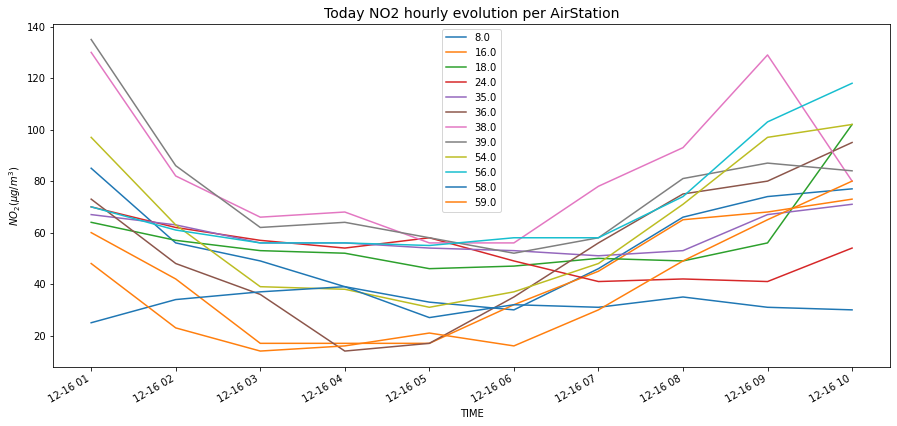

In [23]:
#Plotting NO2 hourly evolution per AirStation
############################################


fig, ax = plt.subplots(figsize=(15,7))

df.groupby("AirStationId")['NO2_index'].plot(ax=ax);

plt.ylabel("$NO_2 (µg/m^3)$")
plt.title("Today NO2 hourly evolution per AirStation",fontsize=14);
plt.legend();

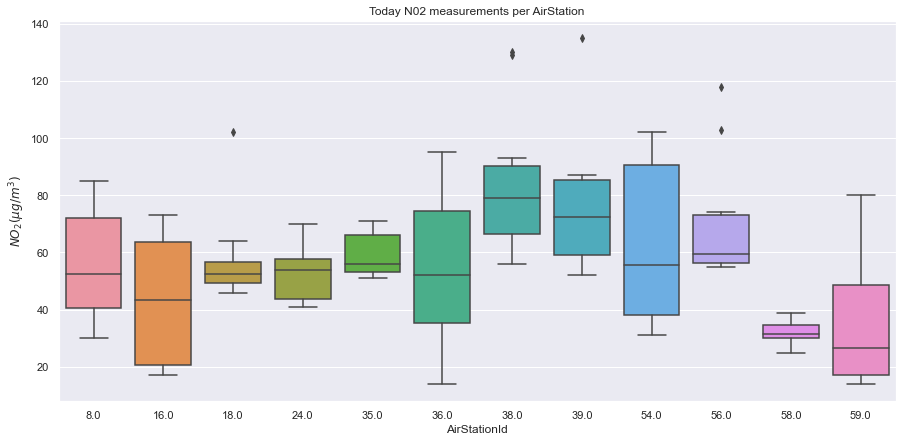

In [24]:
# N02 distribution per AirStation on live data
#############################################

sbn.set(rc={'figure.figsize':(15, 7)})
sbn.boxplot(data=df, x='AirStationId', y='NO2_index').set(title="Today N02 measurements per AirStation", ylabel='$NO_2 (µg/m^3)$');

**Preparing dataframe with live data for prediction**



In [25]:
#Breakingdown the dataframe with all AirStation per AirStation for prediction
#############################################################################

as_groups = df.groupby(df.AirStationId)


try:
    df_4 = as_groups.get_group(4)
except:
    df_4 = None
    
try:    
    df_8 = as_groups.get_group(8)
except:  
    df_8 = None 
    
try:
    df_11 = as_groups.get_group(11)
except:
    df_11 = None
    
try:
    df_16 = as_groups.get_group(16)
except:
    df_16 = None
    
try:   
    df_17 = as_groups.get_group(17)
except:    
    df_17 = None
    
try:
    df_18 = as_groups.get_group(18)
except:    
    df_18 = None
    
try:
    df_24 = as_groups.get_group(24)
except:   
    df_24 = None
    
try:
    df_27 = as_groups.get_group(27)
except:  
    df_27 = None
    
try:
    df_35 = as_groups.get_group(35)
except:   
    df_35 = None
    
try:
    df_36 = as_groups.get_group(36)
except:   
    df_36 = None
    
try:
    df_38 = as_groups.get_group(38)
except:    
    df_38 = None
    
try:
    df_39 = as_groups.get_group(39)
except:   
    df_39 = None
    
try:
    df_40 = as_groups.get_group(40)
except:    
    df_40 = None
    
try:
    df_47 = as_groups.get_group(47)
except:   
    df_47 = None
    
try:
    df_48 = as_groups.get_group(48)
except:  
    df_48 = None
    
try:
    df_49 = as_groups.get_group(49)
except:    
    df_49 = None
    
try:
    df_50 = as_groups.get_group(50)
except:    
    df_50=None
    
try:
    df_54 = as_groups.get_group(54)
except:    
    df_54=None
    
try:
    df_55 = as_groups.get_group(55)
except: 
    df_55 = None
    
try:
    df_56 = as_groups.get_group(56)
except:    
    df_56 = None
    
try:
    df_57 = as_groups.get_group(57)
except:    
    df_57 = None
    
try:
    df_58 = as_groups.get_group(58)
except:    
    df_58 = None
    
try:
    df_59 = as_groups.get_group(59)
except:   
    df_59 = None

try:
    df_60 = as_groups.get_group(60)
except:
    df_60 = None

Due to not all AirStations provide data any time due to communication problems or others, above script create separate dataframe per station even for the ones with no data. 

To these dataframes 24 empty (with NaN values) ROWS have been added to allocate the different predicted values.

In [26]:
#Adding 24 rows to every dataframe to allocate the predictions
########################################################

#Rounding actual prediction time to hours to limit the amount of ROWs to add for prediction
#time2pred = pd.to_datetime(lag)
#time2pred = time2pred.round(freq='H')
#time2pred = time2pred -timedelta(seconds=1)
#Adding 24 ROWS to dataframe to add predicted values
#data = pd.concat([df, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])

In [27]:
#Rounding actual prediction time to hours to limit the amount of ROWs to add for prediction
time2pred = pd.to_datetime(lag)
time2pred = time2pred.round(freq='H')
time2pred = time2pred -timedelta(seconds=1)

#Adding 24 ROWS to every dataframe to add predicted values

if df_4 is not None:
    df_4 = pd.concat([df_4, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_8 is not None:   
    df_8 = pd.concat([df_8, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_11 is not None:    
    df_11 = pd.concat([df_11, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_16 is not None:    
    df_16 = pd.concat([df_16, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_17 is not None:    
    df_17 = pd.concat([df_17, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_18 is not None:     
    df_18 = pd.concat([df_18, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_24 is not None:     
    df_24 = pd.concat([df_24, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_27 is not None:       
    df_27 = pd.concat([df_27, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_35 is not None:    
    df_35 = pd.concat([df_35, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_36 is not None:     
    df_36 = pd.concat([df_36, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_38 is not None:     
    df_38 = pd.concat([df_38, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_39 is not None:     
    df_39 = pd.concat([df_39, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_40 is not None:     
    df_40 = pd.concat([df_40, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_47 is not None:     
    df_47 = pd.concat([df_47, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_48 is not None:     
    df_48 = pd.concat([df_48, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_49 is not None:      
    df_49 = pd.concat([df_49, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_50 is not None:     
    df_50 = pd.concat([df_50, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_54 is not None:       
    df_54 = pd.concat([df_54, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_55 is not None:     
    df_55 = pd.concat([df_55, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_56 is not None:     
    df_56 = pd.concat([df_56, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_57 is not None:      
    df_57 = pd.concat([df_57, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_58 is not None:   
    df_58 = pd.concat([df_58, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_59 is not None:      
    df_59 = pd.concat([df_59, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
if df_60 is not None:     
    df_60 = pd.concat([df_60, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])


In [28]:
df_59

,DATE,DAYWEEK,HOUR,AirStationId,WeatherStationId,NO2_index,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
2021-12-16 00:59:59,2021-12-16,3.0,1.0,59.0,59.0,48.0,0.34,5.0,4.6,63.0,948.0,1.0,0.0
2021-12-16 01:59:59,2021-12-16,3.0,2.0,59.0,59.0,23.0,0.52,1.0,4.4,59.0,948.0,1.0,0.0
2021-12-16 02:59:59,2021-12-16,3.0,3.0,59.0,59.0,14.0,0.55,16.0,4.0,59.0,947.0,1.0,0.0
2021-12-16 03:59:59,2021-12-16,3.0,4.0,59.0,59.0,16.0,0.82,20.0,2.8,63.0,947.0,1.0,0.0
2021-12-16 04:59:59,2021-12-16,3.0,5.0,59.0,59.0,21.0,0.38,2.0,2.2,66.0,947.0,1.0,0.0
2021-12-16 05:59:59,2021-12-16,3.0,6.0,59.0,59.0,16.0,0.37,6.0,1.7,68.0,947.0,1.0,0.1
2021-12-16 06:59:59,2021-12-16,3.0,7.0,59.0,59.0,30.0,0.33,5.0,1.4,69.0,948.0,1.0,0.0
2021-12-16 07:59:59,2021-12-16,3.0,8.0,59.0,59.0,49.0,0.34,14.0,1.1,71.0,948.0,1.0,0.0
2021-12-16 08:59:59,2021-12-16,3.0,9.0,59.0,59.0,65.0,0.38,21.0,1.2,70.0,948.0,9.0,0.0
2021-12-16 09:59:59,2021-12-16,3.0,10.0,59.0,59.0,80.0,0.51,153.0,4.1,64.0,949.0,119.0,0.0


**Load the model**

To load a saved model, all you need to do is pass the “pickled” model into the Pickle load() function and it will be deserialized. By assigning this back to a model object, you can then run your original model’s predict() function, pass in some test data and get back an array of predictions.

In [29]:
#Loading the model previously designed in notebook 4.Modelling SARIMA poc16
###########################################################################

pickled_model = pickle.load(open('../models/poc_16_SARIMAmodel_301_311_12.pkl', 'rb'))

Populating the prediction using 24 hour dynamic window. This is populated in a new field from observed measurements 24 hour

In [44]:
df_16_s = df_16.copy()
df_16_s = df_16[["NO2_index"]]
df_16_s

,NO2_index
2021-12-16 00:59:59,60.0
2021-12-16 01:59:59,42.0
2021-12-16 02:59:59,17.0
2021-12-16 03:59:59,17.0
2021-12-16 04:59:59,17.0
2021-12-16 05:59:59,32.0
2021-12-16 06:59:59,45.0
2021-12-16 07:59:59,65.0
2021-12-16 08:59:59,68.0
2021-12-16 09:59:59,73.0


In [45]:
modelB = sm.tsa.SARIMAX(df_16_s, order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resB = modelB.smooth(pickled_model.params)



pred = resB.predict(start = df_16_s.index[len(df_16_s)-26], end=df_16_s.index[len(df_16_s)-1], dynamic=True)
df_16_s['forecast_24'] = pred
    


/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
<ipython-input-45-a76043acbaab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_16_s['forecast_24'] = pred


In [46]:
df_16_s

,NO2_index,forecast_24
2021-12-16 00:59:59,60.0,NaN
2021-12-16 01:59:59,42.0,NaN
2021-12-16 02:59:59,17.0,NaN
2021-12-16 03:59:59,17.0,NaN
2021-12-16 04:59:59,17.0,NaN
2021-12-16 05:59:59,32.0,NaN
2021-12-16 06:59:59,45.0,NaN
2021-12-16 07:59:59,65.0,NaN
2021-12-16 08:59:59,68.0,NaN
2021-12-16 09:59:59,73.0,75.347942


In [41]:
df_16_s

,NO2_index,forecast_24
2021-12-16 00:59:59,60.0,NaN
2021-12-16 01:59:59,42.0,NaN
2021-12-16 02:59:59,17.0,NaN
2021-12-16 03:59:59,17.0,NaN
2021-12-16 04:59:59,17.0,NaN
2021-12-16 05:59:59,32.0,12.673247
2021-12-16 06:59:59,45.0,10.691141
2021-12-16 07:59:59,65.0,9.262875
2021-12-16 08:59:59,68.0,8.220979
2021-12-16 09:59:59,73.0,7.452634


In [62]:
#prediction on 24hour window
#############################

df_16['forecast_24'] = pickled_model.predict(start=df_16.index[len(df_16)-30], end = df_16.index[len(df_16)-1], dynamic=True)

/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [63]:
df_16


,DATE,DAYWEEK,HOUR,AirStationId,WeatherStationId,NO2_index,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation,forecast_24
2021-12-14 00:59:59,2021-12-14,1.0,1.0,16.0,16.0,17.0,0.530,57.0,5.5,79.0,951.5,0.0,0.0,NaN
2021-12-14 01:59:59,2021-12-14,1.0,2.0,16.0,16.0,17.0,0.585,62.5,5.1,80.0,951.0,0.0,0.0,NaN
2021-12-14 02:59:59,2021-12-14,1.0,3.0,16.0,16.0,11.0,0.580,72.5,4.4,78.0,951.0,0.0,0.0,NaN
2021-12-14 03:59:59,2021-12-14,1.0,4.0,16.0,16.0,9.0,0.640,37.5,3.6,77.0,951.0,0.0,0.0,NaN
2021-12-14 04:59:59,2021-12-14,1.0,5.0,16.0,16.0,10.0,0.550,60.0,3.2,76.0,951.0,0.0,0.0,NaN
2021-12-14 05:59:59,2021-12-14,1.0,6.0,16.0,16.0,11.0,0.505,27.0,3.5,75.0,951.0,0.0,0.0,NaN
2021-12-14 06:59:59,2021-12-14,1.0,7.0,16.0,16.0,21.0,0.450,70.5,3.2,75.0,951.0,0.5,0.0,NaN
2021-12-14 07:59:59,2021-12-14,1.0,8.0,16.0,16.0,38.0,0.505,25.0,3.2,74.0,951.5,0.0,0.0,NaN
2021-12-14 08:59:59,2021-12-14,1.0,9.0,16.0,16.0,47.0,0.505,43.0,3.3,75.0,952.0,7.0,0.0,NaN
2021-12-14 09:59:59,2021-12-14,1.0,10.0,16.0,16.0,43.0,0.550,37.5,4.4,73.0,952.0,108.0,0.0,NaN


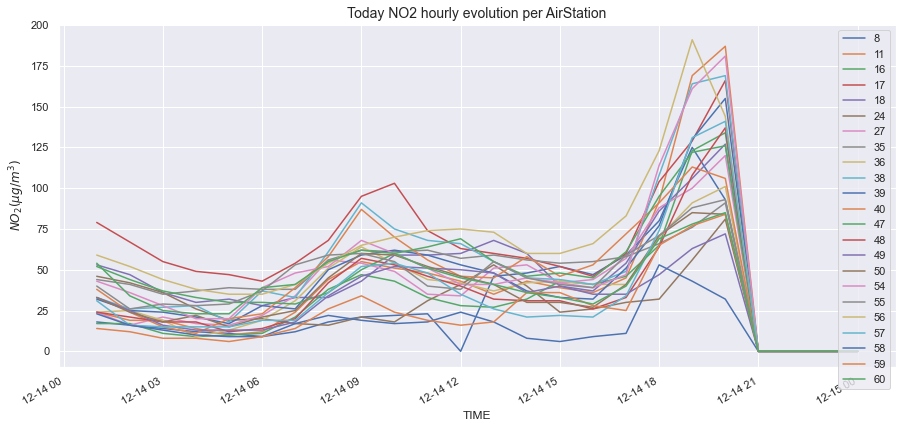

In [21]:
#Plotting NO2 hourly evolution per AirStation
############################################

df_airlive.index = df_airlive.TIME
fig, ax = plt.subplots(figsize=(15,7))

df_airlive.groupby("AirStationId")['NO2_index'].plot(ax=ax);
plt.ylabel("$NO_2 (µg/m^3)$")
plt.title("Today NO2 hourly evolution per AirStation",fontsize=14);
plt.legend();

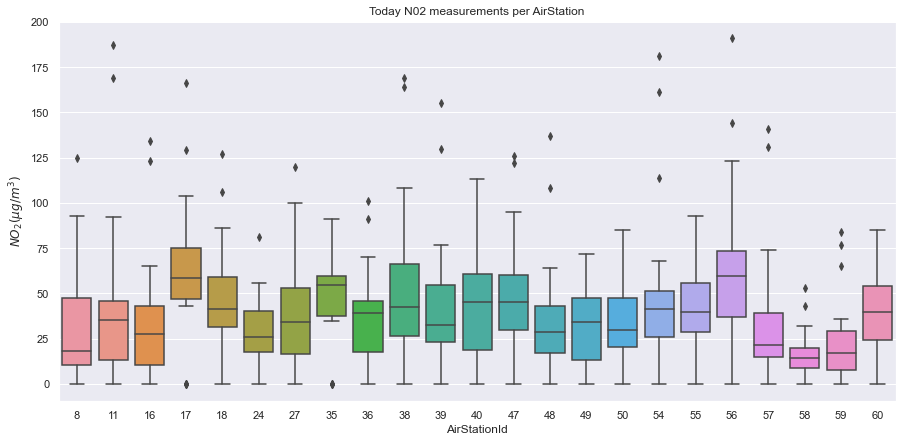

In [22]:
# N02 distribution per AirStation on live data
#############################################

sbn.set(rc={'figure.figsize':(15, 7)})
sbn.boxplot(data=df_airlive, x='AirStationId', y='NO2_index').set(title="Today N02 measurements per AirStation", ylabel='$NO_2 (µg/m^3)$');